<a href="https://colab.research.google.com/github/abakashi/dnc_deliverable2_walmart/blob/main/Deliverable__2_mc_g1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deliverable 2 - Grupo 01 - DEX04
## Importe das bibliotecas e criação do DataFrame.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
from IPython.display import display, HTML, display_html
from itertools import chain,cycle

# Carregando .csv para o DataFrame
dataset = pd.read_csv('/content/drive/MyDrive/Walmart.csv')

# Convertendo os dados de data de String para DateTime
dataset.Date = pd.to_datetime(dataset.Date)

# Criando uma coluna com o número da semana para potencial consulta de 
# resultados
dataset['Week_Number'] = dataset.Date.dt.isocalendar().week


### Sobre os dados
Este é o conjunto de dados de 05-02-2010 até 01-11-2012 do WalmartStoresales. 
Neste arquivo você encontrará as seguintes variáveis:

**Store** - the store number

**Date** - the week of sales

**Weekly_Sales** - sales for the given store

**Holiday_Flag** - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week

**Temperature** - Temperature on the day of sale

**Fuel_Price** - Cost of fuel in the region

**CPI** – Prevailing consumer price index

**Unemployment** - Prevailing unemployment rate

**Holiday Events**\
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\

Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## Questionamento:
**Com base nos dados fornecidos, em qual loja deve-se investir?**

Iniciando os Estudos:

In [16]:
# Criando listas com strings das datas de feriado para comparação futura
christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'] 
thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
labourday_dates = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']

#Nas datas do Superbowl, as lojas não funcionam!!!!!
superbowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']


In [17]:
#Criando funções de utilidades.
# Criando uma função para filtrar os dataframes por lista de datas de feriados
def df_datefilter(dataframe, date_list):
  return dataframe[dataframe.Date.isin(date_list)]

# Criando uma função para pegar as semanas das datas.
def week_getter(datelist):
  weeks = set()
  for date in datelist:
    if date[5] == '0':
      yr = int(date[:4])
      mth = int(date[6:7])
      day = int(date[8:10])
      weeks.add(dt.date(yr, mth, day).isocalendar()[1])
    else:
      yr = int(date[:4])
      mth = int(date[5:7])
      day = int(date[8:10])
      weeks.add(dt.date(yr, mth, day).isocalendar()[1])
  return weeks

# Função para filtrar o dataframe por lista com números de semanas dos feriados
def df_weekfilter(dataframe, weeklist):
  return dataframe[dataframe.Week_Number.isin(weeklist)]

#Função para calcular o limite dos outliers:
def inner_fences(dataframe, variable):
  q1 = dataframe[str(variable)].quantile(0.25)
  q3 = dataframe[str(variable)].quantile(0.75)
  iqr = (q3 - q1) * 1.5
  return (( q1 - iqr ), ( q3 + iqr ))
 
#Função para montar uma tupla com as datas dos quartos de anos
def quarter_getter(year, quarter):
  quarters = (None, ('-01-01', '-03-31'), ('-04-01', '-06-30'),
              ('-07-01', '-09-30'), ('-10-01', '-12-31'))
  dates = list()
  for date in quarters[int(quarter)]:
    dates.append(str(year)+date)
  return tuple(dates)

#Função para montar dataframes por quarters
def ds_quarter_getter(dataframe, year, quarter):
  return dataframe[(dataframe['Date'] >= quarter_getter(year, quarter)[0]) &
                   (dataframe['Date'] <= quarter_getter(year, quarter)[1])]

#Função para plotar os quarters das lojas nos anos
def q_sale_wksl_plotter(dataframe, year):
  q1 = ds_quarter_getter(dataframe, year, 1)[['Store',
      'Weekly_Sales']].groupby('Store').sum().reset_index()
  q2 = ds_quarter_getter(dataframe, year, 2)[['Store',
      'Weekly_Sales']].groupby('Store').sum().reset_index()
  q3 = ds_quarter_getter(dataframe, year, 3)[['Store',
      'Weekly_Sales']].groupby('Store').sum().reset_index()
  q4 = ds_quarter_getter(dataframe, year, 4)[['Store',
      'Weekly_Sales']].groupby('Store').sum().reset_index()


  fig, ax = plt.subplots(2, 2, figsize=(18, 20))
  sns.barplot(x=q1['Weekly_Sales'],y=q1['Store'], orient='h',
              ax=ax[0,0], color="cornflowerblue")
  ax[0,0].set_title(f'Quarter 1 - {year}')
  sns.barplot(x=q2['Weekly_Sales'],y=q2['Store'], orient='h',
              ax=ax[0,1], color="royalblue")
  ax[0,1].set_title(f'Quarter 2 - {year}')
  sns.barplot(x=q3['Weekly_Sales'],y=q3['Store'], orient='h',
              ax=ax[1,0], color="teal")
  ax[1,0].set_title(f'Quarter 3 - {year}')
  sns.barplot(x=q4['Weekly_Sales'],y=q4['Store'], orient='h',
              ax=ax[1,1], color="cadetblue")
  ax[1,1].set_title(f'Quarter 4 - {year}')
  plt.show()

# Definindo função que mostra mais de 1 dataframe por saída
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [18]:
#Checando se as variáveis têm valores nulos
variaveis = list(dataset.columns)
v_nulo = list()
for variavel in variaveis:
  if dataset[variavel].hasnans:
    v_nulo.append(variavel)
print(v_nulo) #sem valores nulos


[]


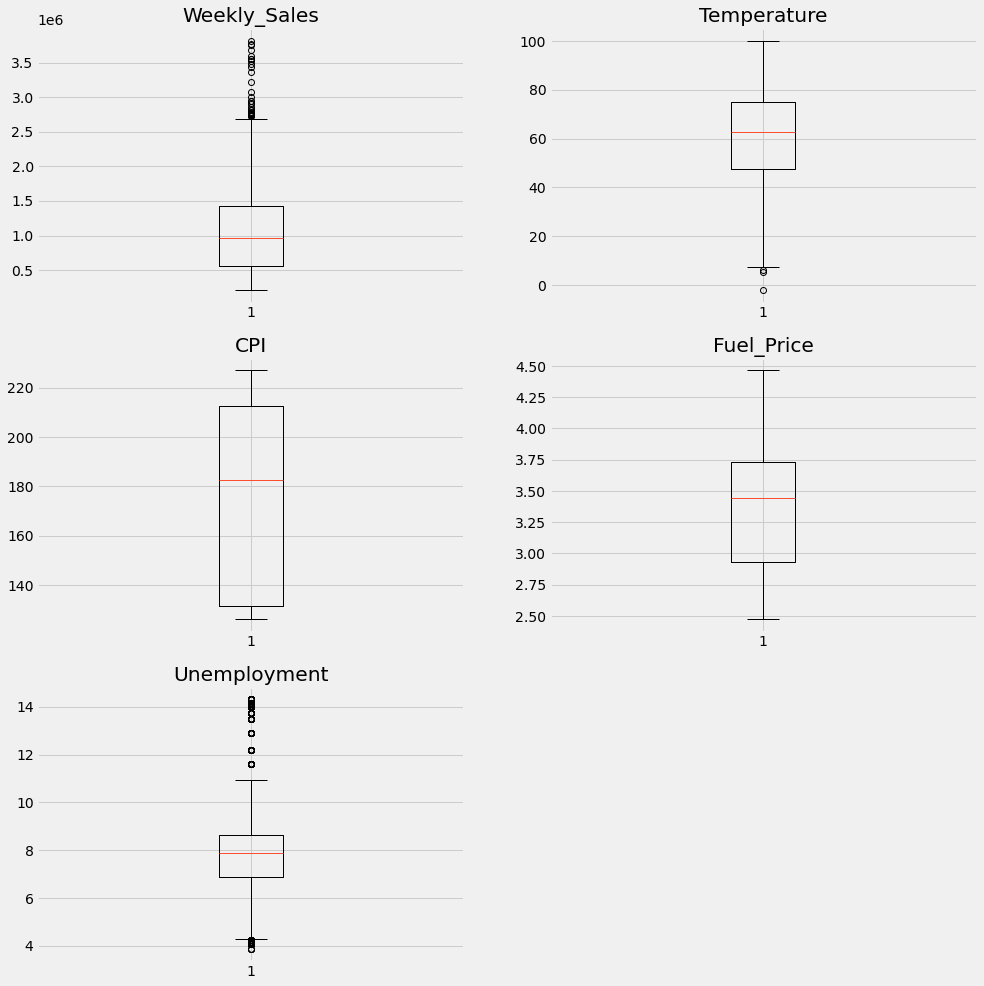

In [19]:
# Visualizando presença de outliers em variáveis quantitativas.

fig, ax = plt.subplots(3,2, figsize=(15,16))

ax[0,0].boxplot(dataset.Weekly_Sales)
ax[0,0].set_title(dataset['Weekly_Sales'].name)

ax[0,1].boxplot(dataset.Temperature)
ax[0,1].set_title(dataset['Temperature'].name)

ax[1,0].boxplot(dataset.CPI)
ax[1,0].set_title(dataset['CPI'].name)

ax[1,1].boxplot(dataset.Fuel_Price)
ax[1,1].set_title(dataset['Fuel_Price'].name)

ax[2,0].boxplot(dataset.Unemployment)
ax[2,0].set_title(dataset['Unemployment'].name)

ax[2,1].set_visible(False)

plt.show()

#outliers detectados no Weekly_Sales (esperado), Temperatura e Unemployment.


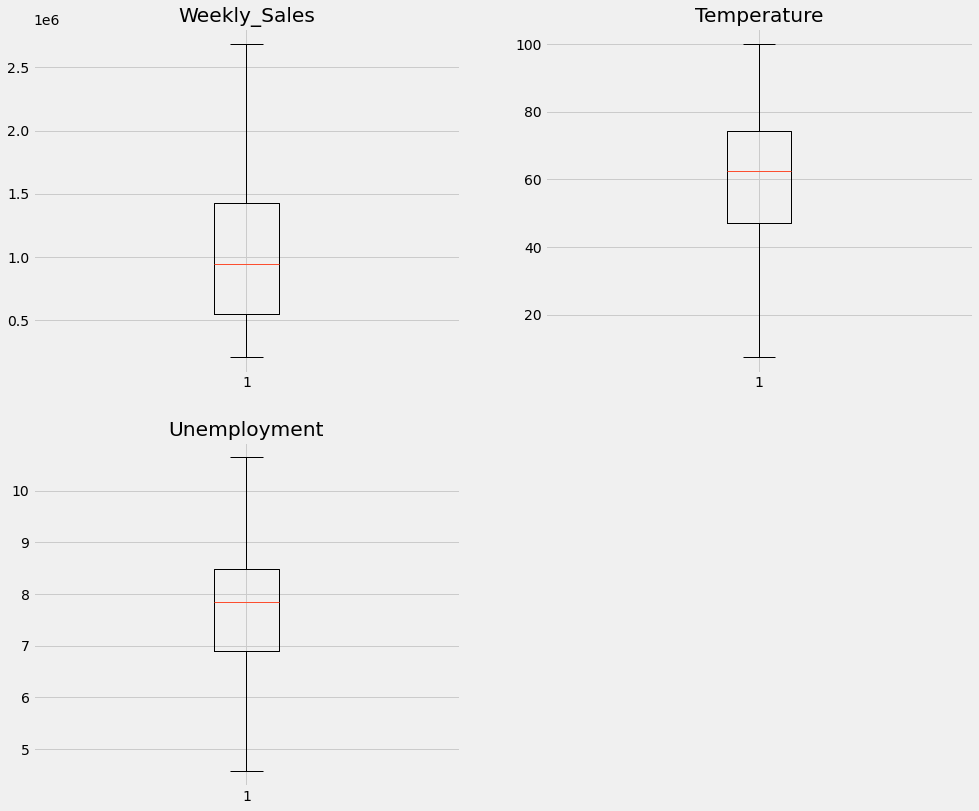

In [20]:
#Removendo Outliers de temperatura e vendas semanais
ds_no_out = dataset.loc[(dataset['Weekly_Sales'] < inner_fences(dataset,
'Weekly_Sales')[1])].loc[(dataset['Temperature'] > inner_fences(dataset,
'Temperature')[0])].loc[(dataset['Unemployment'] > inner_fences(dataset, 
'Unemployment')[0]) & (dataset['Unemployment'] < inner_fences(dataset,
'Unemployment')[1])]

ds_no_out = ds_no_out.loc[(ds_no_out['Unemployment'] > inner_fences(ds_no_out, 
'Unemployment')[0]) & (ds_no_out['Unemployment'] < inner_fences(ds_no_out,
'Unemployment')[1])]

fig, ax = plt.subplots(2,2, figsize=(15,13))

ax[0,0].boxplot(ds_no_out.Weekly_Sales)
ax[0,0].set_title(ds_no_out['Weekly_Sales'].name)

ax[0,1].boxplot(ds_no_out.Temperature)
ax[0,1].set_title(ds_no_out['Temperature'].name)

ax[1,0].boxplot(ds_no_out.Unemployment)
ax[1,0].set_title(ds_no_out['Unemployment'].name)

ax[1,1].set_visible(False)

plt.show()

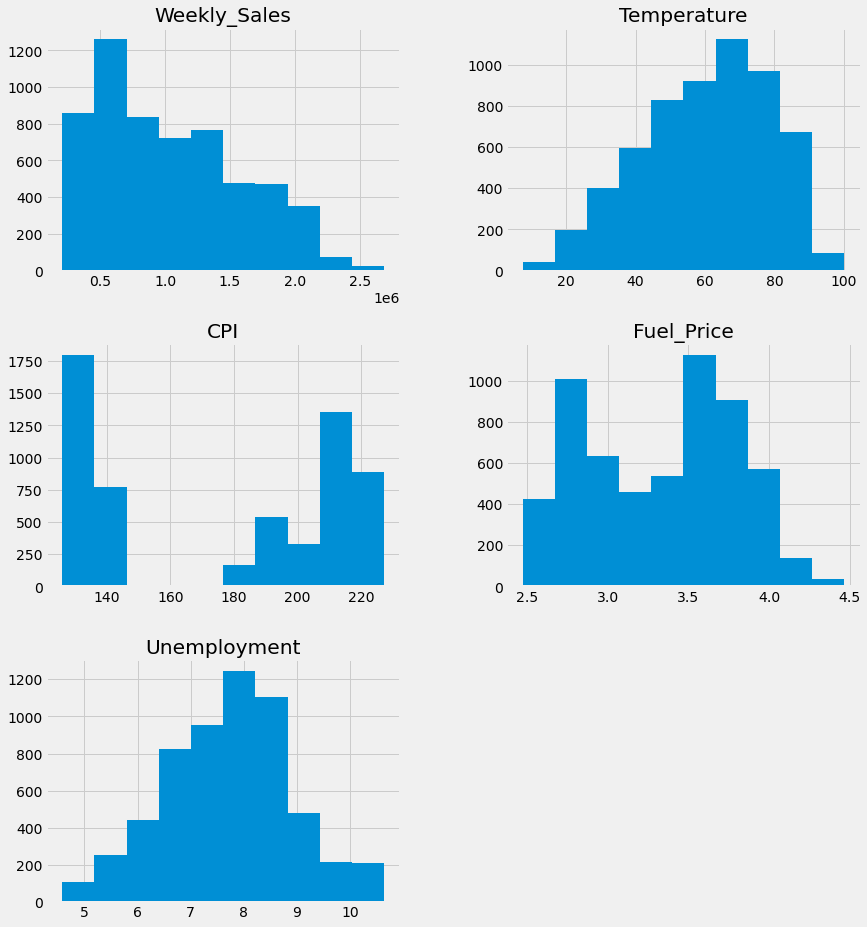

In [21]:
#Visualizando variáveis quantitativas.
plt.style.use('fivethirtyeight')
ds_no_out.hist(column=['Weekly_Sales', 'Temperature', 'CPI', 'Fuel_Price',
                       'Unemployment'], figsize=(13,15))
plt.show()

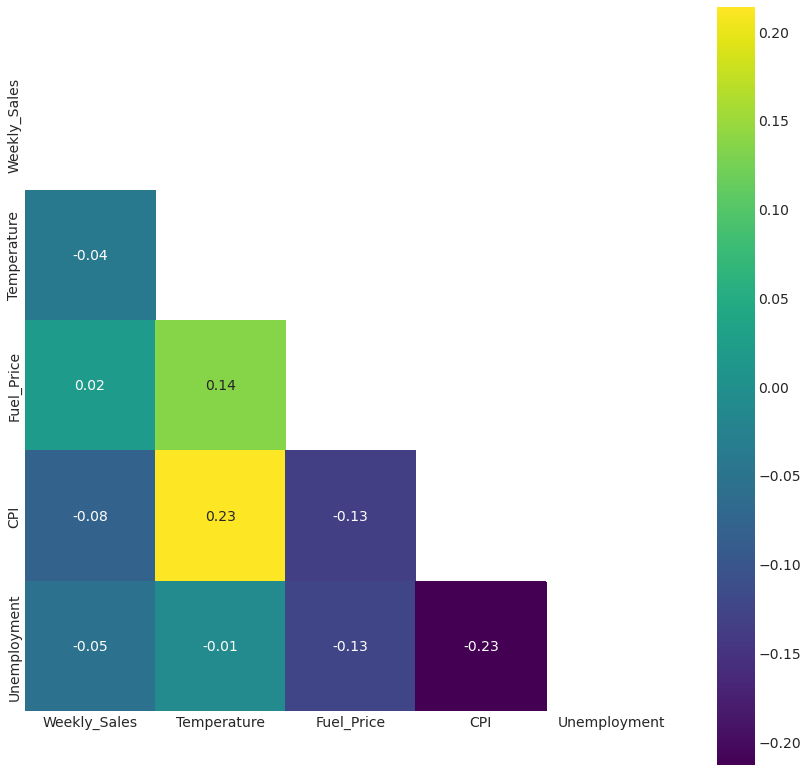

In [22]:
#checagem da matriz de correlação.

ds_hmap = ds_no_out.drop(labels=['Store', 'Date', 'Holiday_Flag', 'Week_Number']
                         , axis=1)

mask = np.zeros_like(ds_hmap.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(13,13))
    ax = sns.heatmap(ds_hmap.corr(),mask=mask, square=True, annot=True,
                     fmt='.2f', cmap='viridis', robust=True)
plt.show()
#Correlação muito fraca das variáveis quantitativas. Atentar para CPI e 
#Unemployment - CPI e Temperature.

##Analisando as vendas semanais dos quarters de 2010.

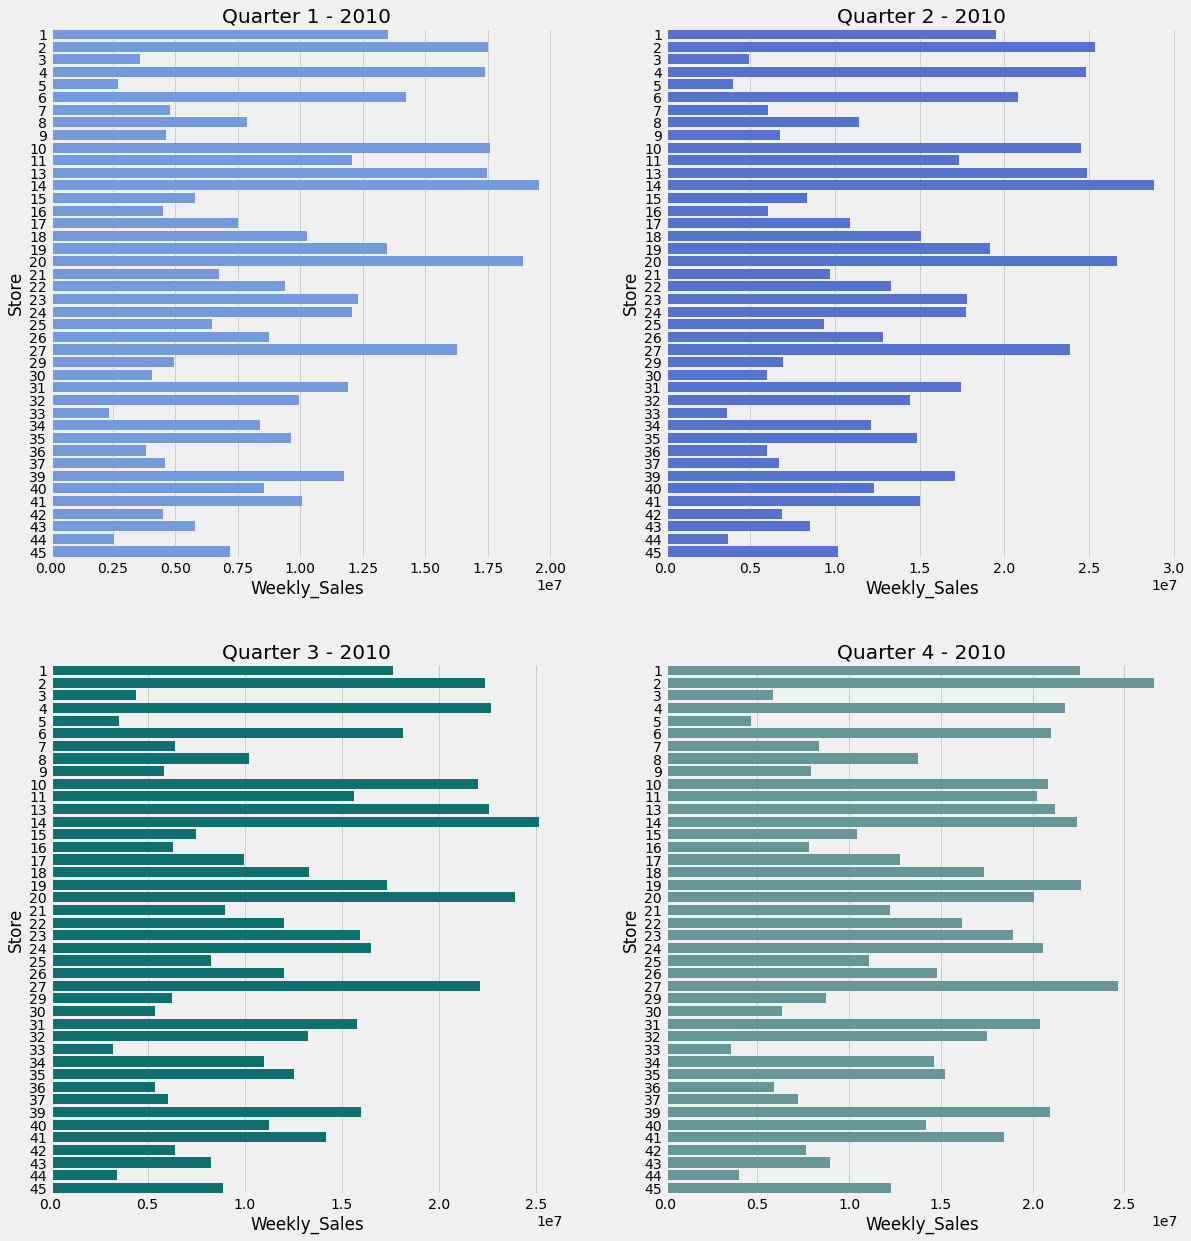

In [23]:
q_sale_wksl_plotter(ds_no_out, 2010)

## Analisando as vendas semanais dos quarters de 2011

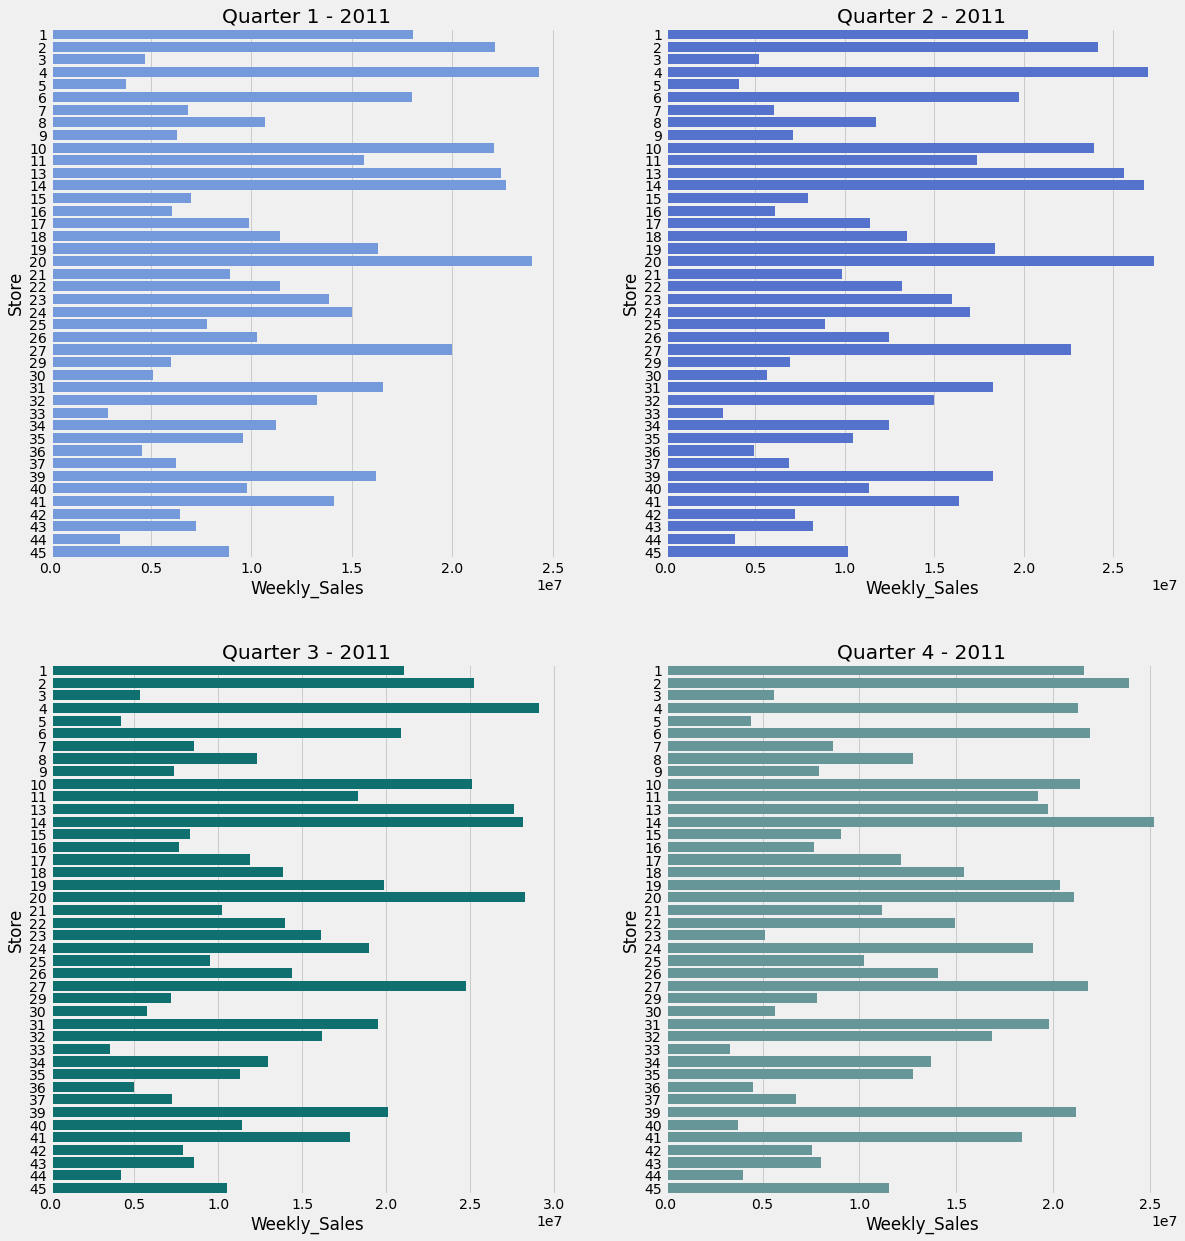

In [24]:
q_sale_wksl_plotter(ds_no_out, 2011)

##Analisando as vendas semanais dos quarters de 2012

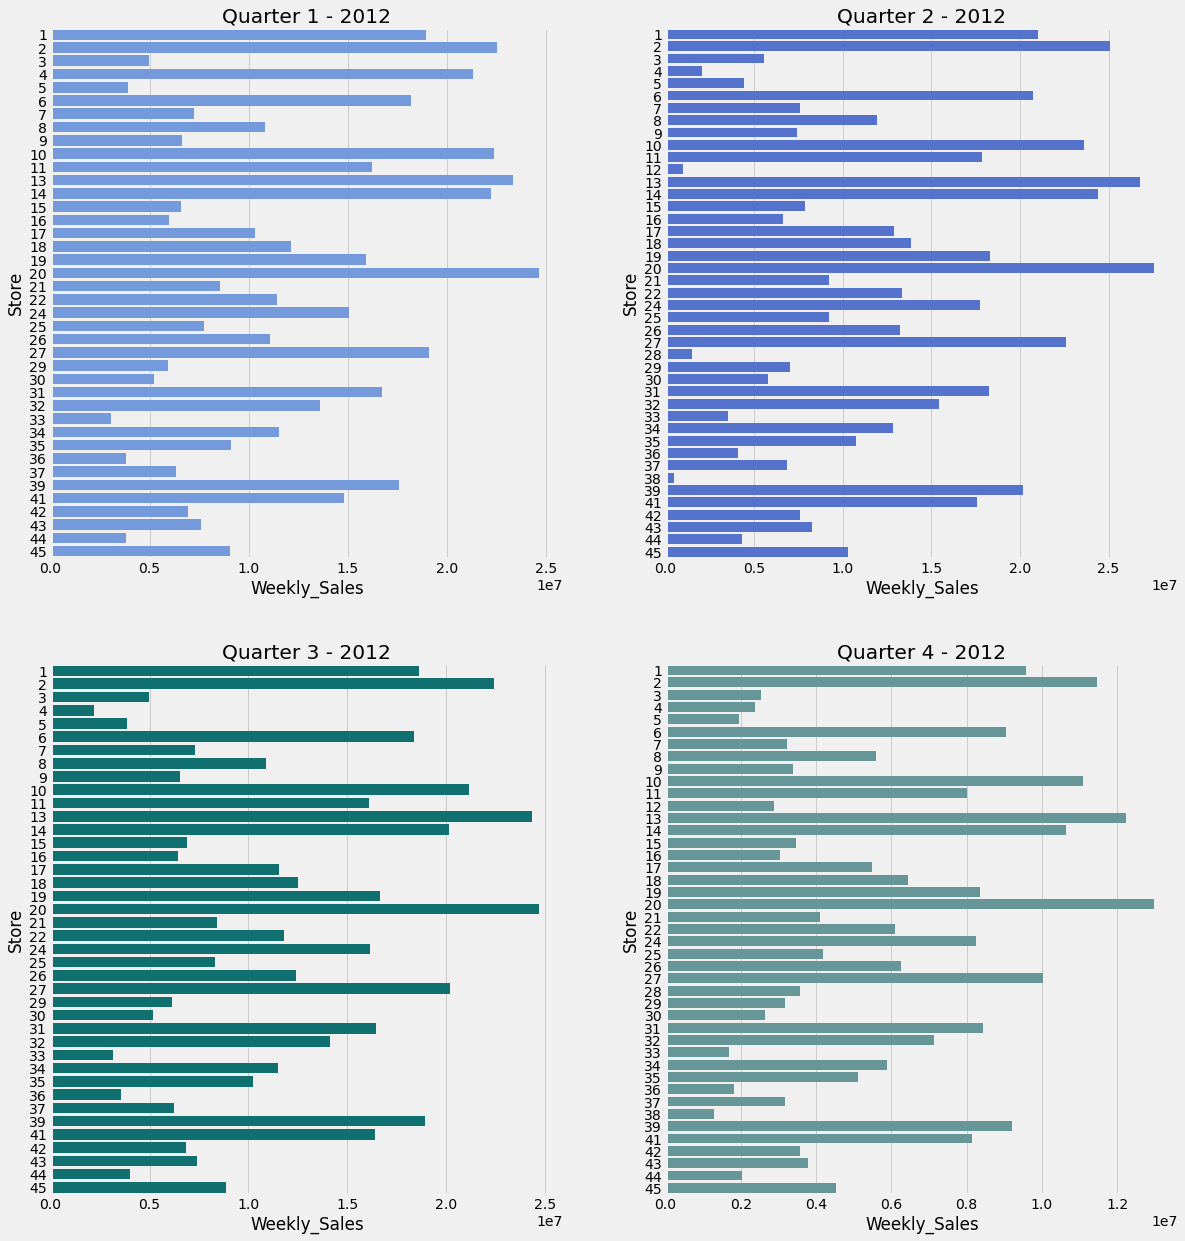

In [25]:
q_sale_wksl_plotter(ds_no_out, 2012)

In [26]:
# Filtrando o dataset por vendas nos feriados de natal (Usando dataset sem Outliers)
ds_christmas = df_weekfilter(ds_no_out, week_getter(christmas_dates))
ds_thanksgiving = df_weekfilter(ds_no_out, week_getter(thanksgiving_dates))
ds_labourday = df_weekfilter(ds_no_out, week_getter(labourday_dates))
ds_superbowl = df_weekfilter(ds_no_out, week_getter(superbowl_dates)) 
#ds_christmas.groupby('Store').sum().sort_values('Weekly_Sales', ascending=False)


# Observando quais lojas mais venderam no feriado do Natal de 2010
chr_2010 = ds_christmas[['Store', 'Date', 'Weekly_Sales']][ds_christmas['Date'
          ].dt.year == 2010].sort_values('Weekly_Sales', ascending=False)

chr_2011 = ds_christmas[['Store', 'Date', 'Weekly_Sales']][ds_christmas['Date'
          ].dt.year == 2011].sort_values('Weekly_Sales', ascending=False)

display_side_by_side([chr_2010, chr_2011], ['2010', '2011'])

,Store,Date,Weekly_Sales
2764,20,2010-12-31 00:00:00,1799737.790000
476,4,2010-12-31 00:00:00,1794868.740000
190,2,2010-12-31 00:00:00,1750434.550000
1334,10,2010-12-31 00:00:00,1707298.140000
1763,13,2010-12-31 00:00:00,1675292.000000
1906,14,2010-12-31 00:00:00,1623716.460000
762,6,2010-12-31 00:00:00,1464050.020000
3765,27,2010-12-31 00:00:00,1440963.000000
47,1,2010-12-31 00:00:00,1367320.010000
2621,19,2010-12-31 00:00:00,1275146.940000


In [31]:
# Observando as vendas semanais nos períodos de ação de graças.
thx_2010 = ds_thanksgiving[['Store', 'Date', 'Weekly_Sales']][ds_thanksgiving[
          'Date'].dt.year == 2010].sort_values('Weekly_Sales', ascending=False)
thx_2011 = ds_thanksgiving[['Store', 'Date', 'Weekly_Sales']][ds_thanksgiving[
          'Date'].dt.year == 2011].sort_values('Weekly_Sales', ascending=False)
thx_2012 = ds_thanksgiving[['Store', 'Date', 'Weekly_Sales']][ds_thanksgiving[
          'Date'].dt.year == 2012].sort_values('Weekly_Sales', ascending=False)

thx_2010

,Store,Date,Weekly_Sales
185,2,2010-11-26,2658725.29
3760,27,2010-11-26,2627910.75
757,6,2010-11-26,2267452.40
430,4,2010-12-02,2188307.39
1288,10,2010-12-02,2176028.52
...,...,...,...
577,5,2010-12-03,297293.59
4577,33,2010-12-02,294882.83
6150,44,2010-12-02,286857.13
6154,44,2010-12-03,272190.83
